In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
#%matplotlib notebook

import matplotlib.pyplot as plt 
import datetime as dt
import matplotlib.dates as mdates
from scipy import stats as st
import numpy as np

# A/B-тест крупного интернет-магазина
У нас есть 3 файла с данными : hypothesis - 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort orders - данные с заказами visitors - данные по визитам пользователей.

Изучим файл с гипотезами, применим фреймворк ICE и RICE для приоритизации гипотез.Посмотрим, как изменилась приоритизация гипотез при разных фреймворках.

1. [Приоритизация гипотез.](#step0) 
2. [Анализ A/B-теста](#step1)
    1. [Кумулятивные графики](#step2)
    2. [Количество и стоимость заказов](#step3)
    3. [Значения по «сырым» данным](#step4)
    4. [Значения по «очищенным» данным](#step5)
3. [Выводы](#step6)

## Гипотезы <a id="step0"></a>

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.columns = map(str.lower, hypothesis.columns)

hypothesis['ICE'] =(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(1)
hypothesis['RICE'] =hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

display(hypothesis.sort_values(by = 'RICE', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


Фреймворк RICE  - поменял нам выдачу приоритетных гипотез относительно фреймворк ICE. Компонент - Reach показывающий скольких пользователей затронет изменение изменил приоритеты с гипотезы "Запустить акцию, дающую скидку на товар" на гипотезу "Добавить форму подписки на все основные страницы" потому что охватывает большее число пользователей. Поcмтрим через percentile 80 - какие гипотезы войдут в первоначальный рабочий план, так как эти 20% изменений дадут нам 80% прибыли в будущем.

In [3]:
print(np.percentile(hypothesis['RICE'], [50, 80]))
print(np.percentile(hypothesis['ICE'], [50, 80]))

[16.2 46.4]
[ 7.   12.04]


Оставим на первоначальный план гипотезы под номерами : 7,2,8,0. Именно они показывают нам что из применение будет для компании максимально эффективно.


## Провели A/B-тест и получили результаты <a id="step1"></a>

In [25]:
orders = pd.read_csv('/datasets/orders.csv', sep=',')
visitors = pd.read_csv('/datasets/visitors.csv', sep=',')

# проверим данные - на пропущенные значения и типы данных
print(orders.info())
print(visitors.info())

# заменим дату на тип datetime
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

display(orders)
display(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


Столбцы в данных из файла orders:
>* transactionId — идентификатор заказа;
>* visitorId — идентификатор пользователя, совершившего заказ;
>* group — группа A/B-теста;
>* revenue — выручка заказа;
>* date — дата заказа.

Столбцы в данных из файла visitors:
>* visitors — число посетителей сайта на заданную дату в определённой группе теста;
>* group — группа A/B-теста;
>* date — дата заказа.

### Посмотрим распределение пользователей между группами А и В

In [5]:
print(orders['group'].value_counts())
print('Начальная дата эксперимента -',visitors['date'].min(), 'Конечная дата эксперимента -',visitors['date'].max())

B    640
A    557
Name: group, dtype: int64
Начальная дата эксперимента - 2019-08-01 00:00:00 Конечная дата эксперимента - 2019-08-31 00:00:00


Всего у нас 640 пользователей в группе В и 557 пользователй в группе А. Эксперимент продолжался один месяц.

Проверим гипотезу о равенстве средних двух генеральных совокупностей , применим метод scipy.stats.ttest_ind. Мы можем использовать этот тест, если мы наблюдаем две независимые выборки из одной и той же или другой популяции

In [26]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [6]:
sample_A = visitors[visitors['group'] == 'A']['visitors'].tolist()
sample_B = visitors[visitors['group'] == 'B']['visitors'].tolist()

alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    sample_A, 
    sample_B)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу для сравнения групп А и B")
else:
    print("Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B")



p-значение:  0.8435238538289684
Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B


Наблюдаемые данные не подтверждают наличие разницы числа пользователей между группами.

### Проверим данные на нормальность. Критерий Шапиро-Уилка

 Проверим нормально ли распределены суммы чеков из наших данных.

In [7]:
chek = orders['revenue'].tolist()
results = st.shapiro(chek)
p_value = results[1] # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: распределение не нормально")
else:
    print("Не получилось отвергнуть нулевую гипотезу, всё нормально")

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


### График кумулятивной выручки по группам  <a id="step2"></a>

In [8]:
# 
datesGroups = orders[['date','group']].drop_duplicates()

orders_agregat = datesGroups.apply(
lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].\
        agg({
'date' : 'max',
'group' : 'max',
'transactionId' : 'nunique',
'visitorId' : 'nunique',
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitors_aggregat = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].\
                        agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

cum = orders_agregat.merge(visitors_aggregat, left_on=['date', 'group'], right_on=['date', 'group'])
cum.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# создадим колонку со средним чеком
cum['chek'] = cum['revenue']/cum['orders']

# считаем кумулятивную конверсию
cum['conversion'] = cum['orders']/cum['visitors']

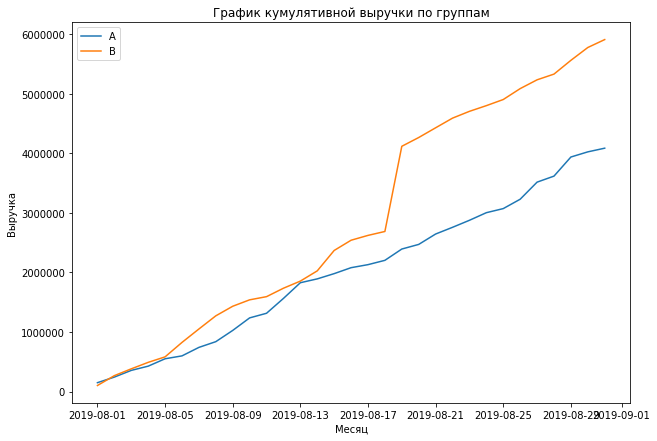

In [9]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(10, 7))
for name in cum['group'].unique():
    srez = cum[cum['group'] == name]
    x = srez['date']
    y =  srez['revenue']
    plt.plot(x,y, label=name)

plt.legend()
plt.title('График кумулятивной выручки по группам')
plt.ylabel('Выручка')
plt.xlabel('Месяц')
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. 
Однако график группы В, в отличии от графика группы А, резко растет. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

### Построим графики среднего чека по группам

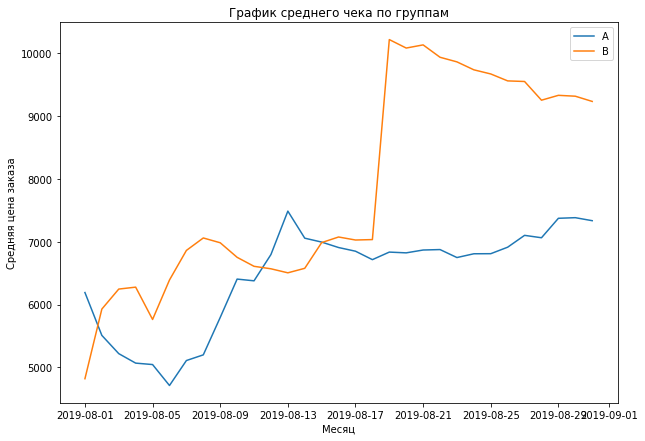

In [10]:
plt.figure(figsize=(10, 7))
for name in cum['group'].unique():
    srez = cum[cum['group'] == name]
    x = srez['date']
    y =  srez['chek']
    plt.plot(x,y, label=name)

plt.legend()
plt.title('График среднего чека по группам')
plt.ylabel('Средняя цена заказа')
plt.xlabel('Месяц')
plt.show()

Средний чек скачет в группе B во второй половине теста, а потом начинает равномерно падать, возможно в какой то момент в группу попали большие заказы. В группе А во второй половине теста средний чек на одном уровне, а в начале текста он резко падал и поднимался. Надо посмотреть график стоимости заказов по пользователям.

### График относительного различия для среднего чека

График относительного изменения кумулятивного среднего чека группы B к группе A


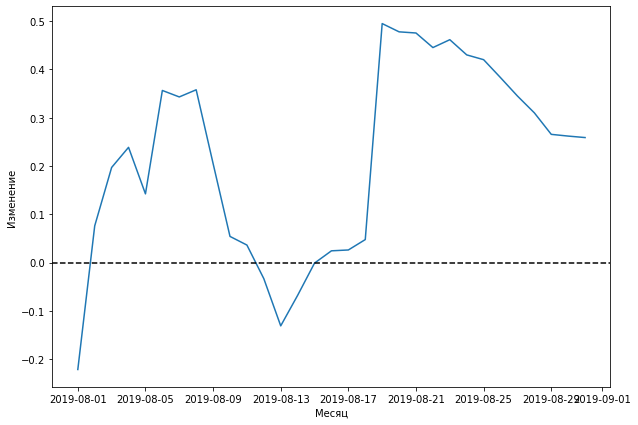

In [11]:
chek = cum[['date','group','chek']].pivot_table(index = 'date',columns = 'group')
chek.columns = chek.columns.map('_'.join)
chek = chek.assign(razlich = lambda x: x['chek_B']/ x['chek_A'] -1)

def otnositelnost(df):
    plt.figure(figsize=(10, 7))
    y =  df['razlich']
    plt.plot(x,y)
    plt.ylabel('Изменение')
    plt.xlabel('Месяц')

    # добавляем ось X
    plt.axhline(y=0, color='black', linestyle='--')

    plt.show()

print('График относительного изменения кумулятивного среднего чека группы B к группе A')
otnositelnost(chek)

В нескольких точках график различия между сегментами резко «скачет», особенно это заметно в точках 09-10 августа и 18-20 августа. Это показывает что в наших данных есть крупные заказы и выбросы

### График кумулятивной конверсии по группам

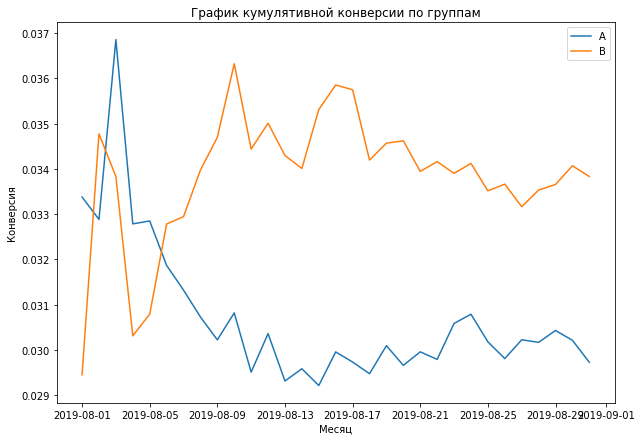

In [12]:
plt.figure(figsize=(10, 7))
for name in cum['group'].unique():
    srez = cum[cum['group'] == name]
    x = srez['date']
    y =  srez['conversion']
    plt.plot(x,y, label=name)

plt.legend()
plt.title('График кумулятивной конверсии по группам')
plt.ylabel('Конверсия')
plt.xlabel('Месяц')
plt.show()

 Группы колебались в начале периода, у обеих групп были зафиксированы всплески около одного значения, но затем конверсия группы В вырвалась вперёд с небольшой корректировкой во второй половине теста, а конверсия группы А просела но находится на небольшом подьеме.

### График относительного изменения кумулятивной конверсии

График относительного изменения кумулятивной конверсии группы B к группе A


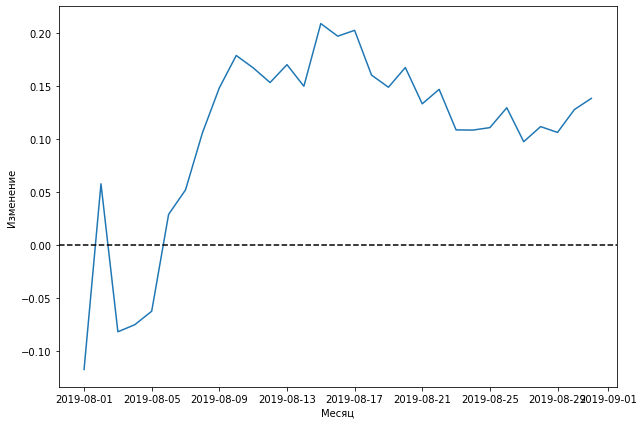

In [13]:
conver = cum[['date','group','conversion']].pivot_table(index = 'date',columns = 'group')
conver.columns = conver.columns.map('_'.join)
conver = conver.assign(razlich = lambda x: x['conversion_B']/ x['conversion_A'] -1)

print('График относительного изменения кумулятивной конверсии группы B к группе A')
otnositelnost(conver)


В начале теста были значительные колебания в конверсии, группа B значительно выигрывала у группы А потом резко проигрывала, затем вырвалась вперёд и показывала превышение В над А на протяжении всего эксперимента. В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. 

Проанализируем аномалии.

### Посмотрим выбросы в данных по чекам и количеству заказов  <a id="step3"></a>

In [14]:
summ_r = orders.groupby('visitorId').agg(countt = ('transactionId', 'nunique')).reset_index()
print('Перцентиль 95 и 99 по стоимости заказов пользователя - ', np.percentile(orders['revenue'], [95, 99]))

Перцентиль 95 и 99 по стоимости заказов пользователя -  [28000.  58233.2]


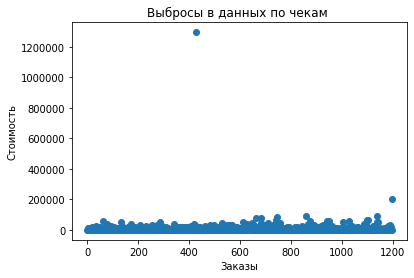

In [15]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.title('Выбросы в данных по чекам ')
plt.xlabel('Заказы')
plt.ylabel('Стоимость')
plt.show()

In [16]:
print('Перцентиль 95 и 99 по количеству заказов пользователя - ', np.percentile(summ_r['countt'], [95, 99]))


Перцентиль 95 и 99 по количеству заказов пользователя -  [2. 4.]


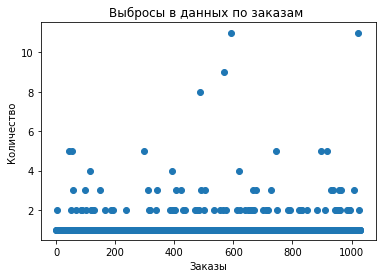

In [17]:
x_values = pd.Series(range(0,len(summ_r['countt'])))
plt.scatter(x_values, summ_r['countt'])
plt.title('Выбросы в данных по заказам ')
plt.xlabel('Заказы')
plt.ylabel('Количество')
plt.show()

Уберем из нашей выборки заказы больше 99 прецентиля - которые выше по стоимости чем - 58233.2 и числом больше 4 на одного пользователя

## Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. <a id="step4"></a>

Начнём с подготовки данных.

In [18]:
# Создадим переменные. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.
ordersA = orders[orders['group']=='A'].groupby('visitorId').agg(orders = ('transactionId', 'nunique')).reset_index()
ordersB = orders[orders['group']=='B'].groupby('visitorId').agg(orders = ('transactionId', 'nunique')).reset_index()
sampleA = pd.concat([ordersA['orders'],pd.Series(0, index=np.arange(cum[cum['group']=='A']['visitors'].\
                                                                   max() - len(ordersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersB['orders'],pd.Series(0, index=np.arange(cum[cum['group']=='B']['visitors'].\
                                                                   max() - len(ordersB['orders'])), name='orders')],axis=0)

print("{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.008
0.138


Вывод: По «сырым» данным различия в конверсии групп A и B есть.
Первое число — p-value =0.008 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет отвергаем. Однако относительный проигрыш  группы А равен 14%

##  Найдём относительные различия в среднем чеке между группами:

In [19]:
print("{0:.3f}".format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.365
0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Средний чек группы B значительно выше среднего чека группы A.

## Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.  <a id="step5"></a>


Примем за аномальных пользователей тех, кто совершил от 4 заказов или совершил заказ дороже 67 750 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами.

Найдем всех аномальных пользователей.

In [20]:
users = pd.concat([ordersA[ordersA['orders'] >= 4]['visitorId'], ordersB[ordersB['orders'] >= 4]['visitorId']], axis = 0)
usersOrders = orders[orders['revenue'] > 58234]['visitorId']
abnormalUsers = pd.concat([users, usersOrders], axis = 0).drop_duplicates().sort_values()

print('Количество пользователей аномальных - ', len(abnormalUsers))

Количество пользователей аномальных -  20


Всего 20 аномальных пользователей.
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [21]:
sampleAFiltered = pd.concat([ordersA[np.logical_not(ordersA['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(cum[cum['group']=='A']['visitors'].\
                                                                   max() - len(ordersA)), name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersB[np.logical_not(ordersB['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(cum[cum['group']=='B']['visitors'].\
                                                                   max() - len(ordersB)), name='orders')],axis=0)

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [22]:
print("{0:.3f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.007
0.151


Результаты не изменились. В выигрывает у А по конверсии на 15%

## Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [23]:
print("{0:.3f}".format(st.mannwhitneyu(orders[np.logical_and(orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and( orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

0.479
-0.014


P-value увеличился, но и разница между сегментами сократилась и теперь средний чек группы В даже немного меньше группы А.Такой пример хорошо показывает, как сильно аномалии могут влиять на результаты A/B-теста!

## Результаты  <a id="step6"></a>

### Гипотезы

Оставим на первоначальный план гипотезы под номерами : 7,2,8,0.

7.  Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
2. 	Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
0. 	Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	
8.	Запустить акцию, дающую скидку на товар в день рождения	


Именно они получили максимальный приоритет при обработке с помощью фреймворков -  RICE и  ICE. Полученные данные при использовании обоих фреймворков показывают нам, что применение именно этих гипотез будет для компании максимально эффективно.

### А\В тестирование

По конверсии по очищеным данным - выигрывает группа В на 15%, а по среднему чеку получаеться что выигрывает группа А, правда всего на 1,5% . График относительного изменения кумулятивной конверсии группы B к группе A сообщает, что результаты группы А хуже группы В и нет значительной тенденции к улучшению.

Исходя из обнаруженных фактов, тест следует остановить и признать победу группы В.